# **Demand Planning**

This practice dataset comes from Kaggle's Store Item Demand Forecasting Challenge found at https://www.kaggle.com/c/demand-forecasting-kernels-only

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

# **Setup**

In [1]:
# Import packages

# set the current working directory 
import os
os.getcwd()
base = '/content'
os.chdir(base)
# path = /content/train.csv

# data cleaning and viz packages
import pandas as pd
#import scipy as sp
import statsmodels as sm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from datetime import date
import calendar as calendar
!pip install holidays
import holidays
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# time series modeling packages
!pip install pmdarima
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape
from pmdarima.arima import StepwiseContext

# yfinance
!pip install yfinance
import yfinance as yfimport 


# prophet
!pip install pystan==2.19.1.1
!pip install fbprophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 29.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


     |████████████████████████████████| 6.4 MB 7.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# **Import data**

In [2]:
# Import data 
df = pd.read_csv(base + '/train.csv') # imports data as a data frame

df.head(10) # preview first 10 rows

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


# **Exploratory Data Analysis**

In [3]:
# find uniqure values for columns to determine spread of data
df["store"].unique() # 10 different stores

df["item"].unique() # 50 different items

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [4]:
# Convert date to a date/time var
df['date'] =  pd.to_datetime(df['date'])

# convert store and item into text
df['store'] = df['store'].apply(lambda store: str(store)) 
df['item'] = df['item'].apply(lambda item: str(item)) 
print(df.dtypes)


# sort by date important for time series
df = df.sort_values(by=['date','store','item'])
df.head(10)

date     datetime64[ns]
store            object
item             object
sales             int64
dtype: object


,date,store,item,sales
0,2013-01-01,1,1,13
164340,2013-01-01,1,10,37
182600,2013-01-01,1,11,37
200860,2013-01-01,1,12,33
219120,2013-01-01,1,13,37
237380,2013-01-01,1,14,22
255640,2013-01-01,1,15,42
273900,2013-01-01,1,16,14
292160,2013-01-01,1,17,13
310420,2013-01-01,1,18,38


# **Date Manipulations**

In [5]:
### Extract month, day, year from Date into separate columns

# Extract month.
df['month'] = pd.DatetimeIndex(df['date']).month

# Extract day.
df['day_of_month'] = pd.DatetimeIndex(df['date']).day

# Extract year.
df['year'] = pd.DatetimeIndex(df['date']).year

# Extract quarter.
df['quarter'] = pd.DatetimeIndex(df['date']).quarter

### separate out year and month into their own varialbles for eventual dummy variables

# years
df['year_2013']= np.where(df['year'] == 2013, 1, 0)
df['year_2014']= np.where(df['year'] == 2014, 1, 0)
df['year_2015']= np.where(df['year'] == 2015, 1, 0)
df['year_2016']= np.where(df['year'] == 2016, 1, 0)
df['year_2017']= np.where(df['year'] == 2017, 1, 0)

# months
df['jan_dum']= np.where(df['month'] == 1, 1, 0)
df['feb_dum']= np.where(df['month'] == 2, 1, 0)
df['mar_dum']= np.where(df['month'] == 3, 1, 0)
df['apr_dum']= np.where(df['month'] == 4, 1, 0)
df['may_dum']= np.where(df['month'] == 5, 1, 0)
df['jun_dum']= np.where(df['month'] == 6, 1, 0)
df['july_dum']= np.where(df['month'] == 7, 1, 0)
df['aug_dum']= np.where(df['month'] == 8, 1, 0)
df['sept_dum']= np.where(df['month'] == 9, 1, 0)
df['oct_dum']= np.where(df['month'] == 10, 1, 0)
df['nov_dum']= np.where(df['month'] == 11, 1, 0)
df['dec_dum']= np.where(df['month'] == 12, 1, 0)

# extract week day
df['Day of Week'] = df['date'].apply(lambda date: calendar.day_name[date.weekday()]) 

# extract if date falls on a weekend or not. Is the day saturday or sunday - could possibly include friday as weekend.
df['isweekend']= np.where((df['Day of Week'] == "Saturday")| (df['Day of Week'] == "Sunday"), 1, 0)

df.head()

,date,store,item,sales,month,day_of_month,year,quarter,year_2013,year_2014,year_2015,year_2016,year_2017,jan_dum,feb_dum,mar_dum,apr_dum,may_dum,jun_dum,july_dum,aug_dum,sept_dum,oct_dum,nov_dum,dec_dum,Day of Week,isweekend
0,2013-01-01,1,1,13,1,1,2013,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Tuesday,0
164340,2013-01-01,1,10,37,1,1,2013,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Tuesday,0
182600,2013-01-01,1,11,37,1,1,2013,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Tuesday,0
200860,2013-01-01,1,12,33,1,1,2013,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Tuesday,0
219120,2013-01-01,1,13,37,1,1,2013,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Tuesday,0


**Typically holidays would be an important consideration for time series analyses, but in the Data Description section of our dataset, we were told that holidays were not in effect - so this portion of code will be commented out here but will remain useful for other projects. https://www.kaggle.com/c/demand-forecasting-kernels-only/data**

In [6]:
# does date fall on a holiday or not. assuming US holidays.
# https://towardsdatascience.com/5-minute-guide-to-detecting-holidays-in-python-c270f8479387
# full list of supported holidays in over 50 countries -> https://pypi.org/project/holidays/


# preview list of reocgnized holidays for the years in our dataset
# you might want to append other relevant holidays that are not recognized in this list that may have an effect on sales 
# such as Black Friday in the US or company/industry-specific holidays (ex: valentine's day may be more relevant for a jewler than a furniture store)
#years = [2013,2014,2015,2016,2017]
#for date in holidays.UnitedStates(years=years).items():
#   print(date)    

# save the holidays as a separate string to compare against the df 
#US_Holidays = []
#for date in holidays.UnitedStates(years=years).items():
#    US_Holidays.append(str(date[0]))
#df['holidays'] = np.where(datetime.df['date'].isin(holidays), 1,0)

#US_Holidays

# create a separare date value as a string so we can compare to the US holidays string list
#df['date_as_string'] = date.strftime('%m/%d/%Y')
#df['date_as_string'] = df['date'].apply(lambda date: date.strftime('%m/%d/%Y'))
#print(df.dtypes)

# mark date as 1 if it falls on a US holiday, zero otherwise
#df["holiday"] = np.where(df["date"].isin(US_Holidays), 1, 0)

# double check for 1/1/2013 and 7/4/2013
#df.head(189)

In [7]:
# Determines how many years we are working across. In this case, 5 years - 2013,2014,2015,2016,2017.
df["year"].nunique() # 5 different years
df["month"].nunique() # all months
df["day_of_month"].nunique() # all days

31

In [8]:
# Find null values. Filling null values is essential for TS modeling if they exist.
df.isnull().sum()

date            0
store           0
item            0
sales           0
month           0
day_of_month    0
year            0
quarter         0
year_2013       0
year_2014       0
year_2015       0
year_2016       0
year_2017       0
jan_dum         0
feb_dum         0
mar_dum         0
apr_dum         0
may_dum         0
jun_dum         0
july_dum        0
aug_dum         0
sept_dum        0
oct_dum         0
nov_dum         0
dec_dum         0
Day of Week     0
isweekend       0
dtype: int64

# **Visualize the data**

In [9]:
#sns.displot(x = df['sales'])

In [10]:
#sns.pairplot(df)

In [11]:
# Observe if seasonality may be present
# summer months seem to bring the most sales, with exception of november. black friday? christmas shoppers?
#sns.barplot(x = df['month'], y = df['sales'])

In [12]:
# Look for potential outliers and high erforming stores
# store 2 looks like a high performing store with potential outliers
# store 9 appears to have potential outliers as well
# stores 5-7 a little weaker performance
#sns.stripplot(y = df['sales'], x = df['store'])

In [13]:
# describe the df to get summary stats
#df.describe()

In [14]:
# Show the overall pattern of sales data over time 
#fig, ax = plt.subplots(figsize=(20,10))  
#sns.lineplot(x="date", y="sales", data=df, color = 'purple')

In [15]:
# Show facet grid to compare store sales trends side by side
#sns.relplot(
#    data=df, x="date", y="sales",
#    col="store", color = "purple",
#    kind="line"
#)

In [16]:
# heatmap for correlation
#fig, ax = plt.subplots(figsize=(20,10))  
#sns.heatmap(df.corr(), annot = True, cmap = 'gnuplot2_r')

### **Time Series Modeling**

https://medium.com/mlearning-ai/automating-time-series-forecasting-ae74190408be

# **PMDArima**
https://towardsdatascience.com/efficient-time-series-using-pythons-pmdarima-library-f6825407b7f0 https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

In [17]:
# Here I am going to get a baseline model using just the date and sales before I begin to incorporate other features
# Create a separate DF for this base run
base_model_df = df[['date', 'store', 'sales']].copy()

# set the date column as an index
base_model_df.set_index('date',inplace=True)

base_model_df.head()

,store,sales
date,,
2013-01-01,1,13
2013-01-01,1,37
2013-01-01,1,37
2013-01-01,1,33
2013-01-01,1,37


In [18]:
# Split the data intro train and test groups.
# The orignal Kaggle prompt asked us to predict the last 3 months of sales transactions
#num_stores = base_model_df["store"].nunique()
#len(base_model_df) # total num of rows
#positionfirst75 = len(base_model_df)*0.75
#positionfirst75

# gets most recent date
most_recent_date = base_model_df.index.max()
most_recent_date

# subtract 3 motnhs from most recent date. DateOffset > https://thispointer.com/subtract-months-from-a-date-in-python/
past_3months = most_recent_date - pd.DateOffset(months=3)
past_3months 

# find the iloc position where this date first appears. this will tell us where to cut off the train/test groups
get3months_loc = base_model_df.index.get_loc('2017-09-30 00:00:00')
get3months_loc


# Be careful using sklearn's train test split here because this data is ordered by date and the ordering matters. sklearn's train test split shuffles the data when using its default parameters
# if you want to use sklearn's train test split, use the shuffle=False parameter
# create indicator varible for train_test_group. 
base_model_df['train_test_group'] = base_model_df[['sales']].copy() # add copy of sales column as a placeholder
base_model_df.loc[:866500, "train_test_group"] = 'train'
base_model_df.loc[866500:, "train_test_group"] = 'test'
base_model_df.head(-10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning:

Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning:

Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.



,store,sales,train_test_group
date,,,
2013-01-01,1,13,train
2013-01-01,1,37,train
2013-01-01,1,37,train
2013-01-01,1,33,train
2013-01-01,1,37,train
...,...,...,...
2017-12-31,9,22,test
2017-12-31,9,49,test
2017-12-31,9,61,test


In [19]:
# Show facet grid to compare store sales train and test side by side
#sns.relplot(
#    data=base_model_df, x="date", y="sales",
#    col="store", hue= "train_test_group", 
#    kind="line"
#)

In [20]:
# isolate the train df into its own dataset
train = base_model_df[['store', 'sales','train_test_group']].copy()
train = train[train.train_test_group != "test"] # remove all test obs
train = train.drop('train_test_group', 1) # drop train/test column for data analysis - where 1 is the axis number (0 for rows and 1 for columns.)
train = train.drop('store', 1) # drop store column for data analysis - where 1 is the axis number (0 for rows and 1 for columns.)
train.head(-10)

# isolate the test df into its own dataset
test = base_model_df[['store', 'sales','train_test_group']].copy()
test = test[test.train_test_group != "train"]
test = test.drop('train_test_group', 1) # drop train/test column for data analysis - where 1 is the axis number (0 for rows and 1 for columns.)
test = test.drop('store', 1) # drop store column for data analysis - where 1 is the axis number (0 for rows and 1 for columns.)
test.head(-10)



,sales
date,
2017-09-30,30
2017-09-30,74
2017-09-30,82
2017-09-30,75
2017-09-30,105
...,...
2017-12-31,22
2017-12-31,49
2017-12-31,61


**ADF Test for Stationarity**

In [21]:
# use pmdarima’s ADFTest() function to conduct an Augmented Dickey-Fuller test. 
# this is the test that determines if our model is stationary or not, or had a constant mean and variance over time
# The null hypothesis of the test is that the time series is not stationary, while the alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
adf_test=ADFTest(alpha=0.05)

# If the output above shows that the p-value is greater than the significance level of 0.05, 
# we fail to reject the null hypothesis. This means series is not stationary and requires differencing:
adf_test.should_diff(train)

# # Output
# # (0.01, False)
# # This result of p = 0.01 means we can reject the null hypothesis - this result indicates that the data is stationary and we should not difference it
# # If we had refuse to reject the null hypothesis, we need to use the “Integrated (I)” concept (d parameter) to make the data stationary by differencing while building the Auto ARIMA model.

(0.01, False)

In [22]:
# NOTE: If the model is not stationary, the functions below tell you what the optimal d value is:

# Estimate the number of differences using an ADF test:
#from pmdarima.arima.utils import ndiffs
#n_adf = ndiffs(train, test='adf')  
#n_adf 
# The model outputs 0, confirming we do not need to difference 

# Or a KPSS test (auto_arima default):
#n_kpss = ndiffs(train, test='kpss')  
#n_kpss
# The model outputs 0, confirming we do not need to difference 

In [23]:
# convert sales data type to smaller type for handling
#train['sales'] = train['sales'].astype(np.uint8)

# In the Auto ARIMA model, note that small p,d,q values represent non-seasonal components, 
# and capital P, D, Q represent seasonal components.
# Here, we are trying with the p, d, q values ranging from 0 to 5 to get better optimal values from the model.

# Below are what the function's parameter inputs mean, from https://alkaline-ml.com/pmdarima/tips_and_tricks.html
# seasonal=True tells the model to automatically estimate the seasonality differencing term 
# does m need to = max_D?
# m parameter relates to the number of observations per seasonal cycle. Typically, m will correspond to some recurrent periodicity such as 1 for annually, 12 for monthly, 52 for weekly, 365 for daily, etc
# stepwise=True is encouraged in each model. This runs several recommended models (exact models available in linked documentation above) and selects the one with the lowerst AIC
# StepwiseContext sets the maximum time duration and/or maximum number of steps for your model. Setting a time constraint can be helpful in preventing your model from spinning endlessly

#pmdarima_model = pm.auto_arima(train,error_action='ignore',start_p=0, d=1, start_q=0,
#                           max_p=2, max_d=2, max_q=2,
#                           start_P=0, D=1, start_Q=0, Max_P=2, max_D=12, max_Q=2, m=12, seasonal=True,
#                            error_action ='warn',
#                           trace = True, supress_warnings=True, stepwise=True, random_state=20, n_fits = 5)
#with StepwiseContext(max_steps=5):
#    with StepwiseContext(max_dur=5):
#        pmdarima_model = pm.auto_arima(train, stepwise=True, error_action='ignore', seasonal=True, scoring='mse') #, m=365)

In [24]:
#pmdarima_model.summary()

# **PLACEHOLDER IMAGE FOR OUTPUT WITH NO M PARAMETER**
The SARIMAX(2,1,2) model was chosen as the best model whether we allowed for 5 steps or 20 steps

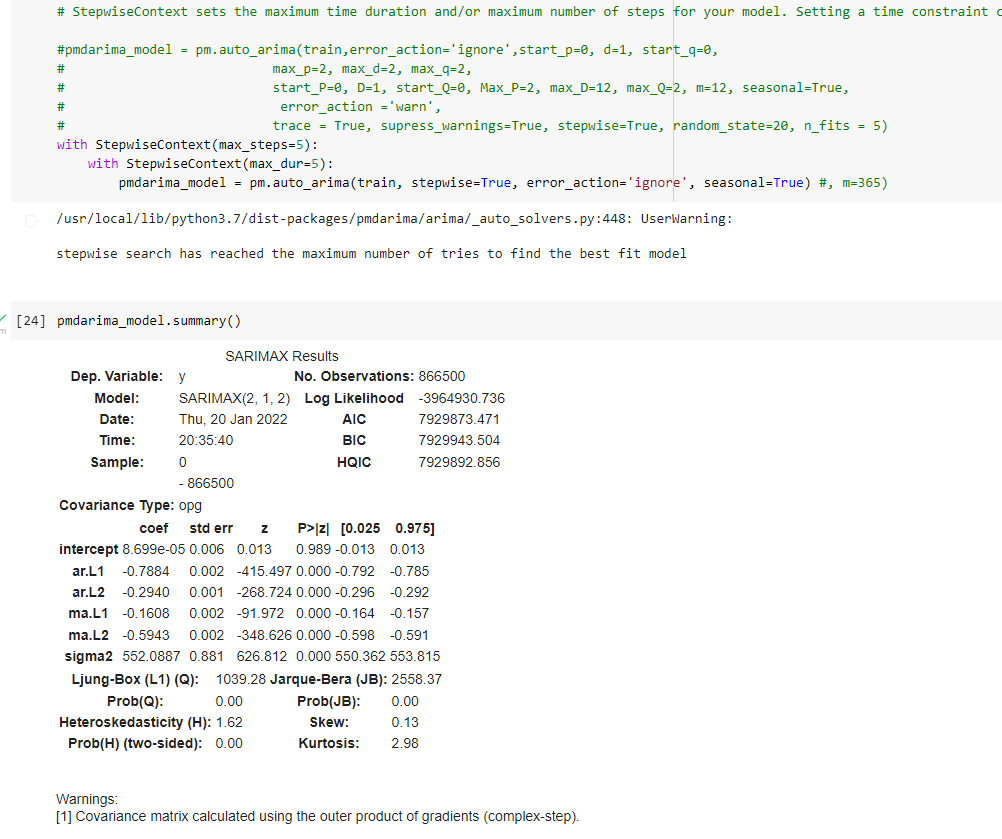

# **FBProphet**

In [25]:
# Rename columns to fit prophet syntax. Dependent var must be called y and independent must be called ds
# https://facebook.github.io/prophet/docs/quick_start.html
# Here there is code to add holidays to FBProphet https://medium.com/red-buffer/fbprophet-your-solution-to-any-forecasting-problem-f17eb33ecfa0
train.reset_index(inplace=True)
train = train.rename(columns = {'date':'ds'})
train.rename(columns={'sales': 'y'}, inplace=True)

train.head()

,ds,y
0,2013-01-01,13
1,2013-01-01,37
2,2013-01-01,37
3,2013-01-01,33
4,2013-01-01,37


In [26]:
print(train.dtypes)

ds    datetime64[ns]
y              int64
dtype: object


In [27]:
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
# predict next 3 months like original prompt wanted
# When we keep include_history as True in prediction, the model does an in-sample fit as well (gives predictions for the training dataset as well). You can use this to judge better how well the model has fit both the past and future data.
# https://medium.com/red-buffer/fbprophet-your-solution-to-any-forecasting-problem-f17eb33ecfa0
future = m.make_future_dataframe(periods=93, include_history=True) # periods = 93 to get us all the way to the end of year at 12/31/2017
future.tail()

,ds
1821,2017-12-27
1822,2017-12-28
1823,2017-12-29
1824,2017-12-30
1825,2017-12-31


In [35]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1821,2017-12-27,41.330539,7.297286,73.683243
1822,2017-12-28,44.620898,12.027632,78.998239
1823,2017-12-29,48.066836,17.833379,81.386481
1824,2017-12-30,51.491890,18.388125,85.107855
1825,2017-12-31,54.908084,23.026991,89.411395


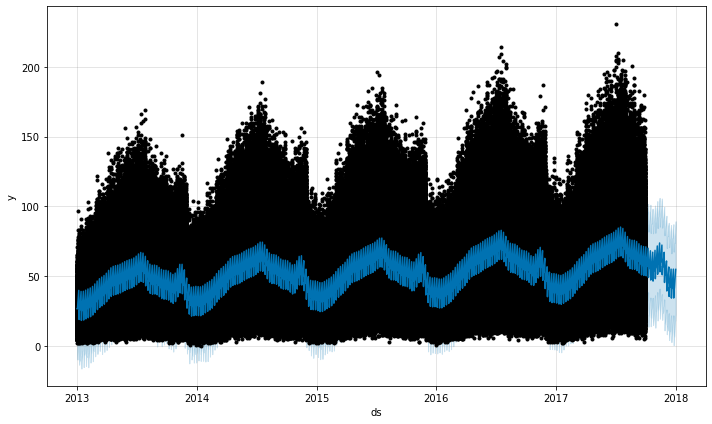

In [36]:
fig1 = m.plot(forecast)


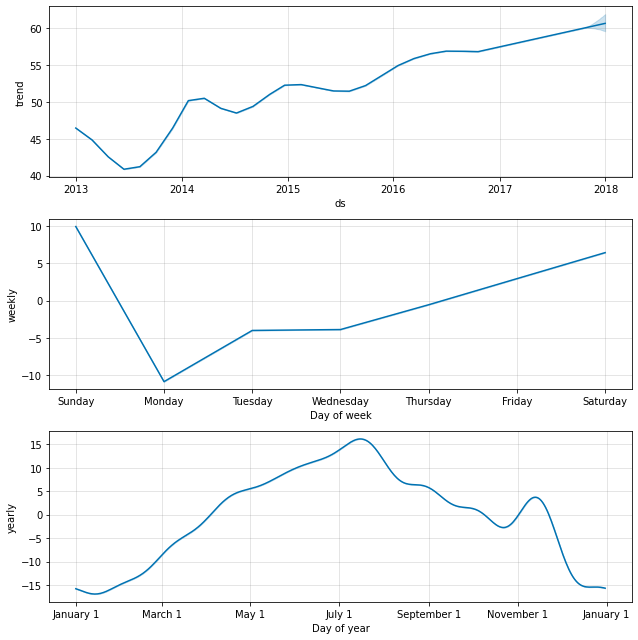

In [37]:
fig2 = m.plot_components(forecast)


In [48]:
# fbprophet model accuracy metrics
# Overivew of differences between metrics: https://analyticsindiamag.com/a-guide-to-different-evaluation-metrics-for-time-series-forecasting-models/

# calculate MAE between expected and predicted values
y_true = train['y'][864674:].values #only capture the same dates that are in forecast. Size of traindf-size of forecast df, or 866500-1826
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)
# MAE is defined as the average of the absolute difference between forecasted and true values.
# A value of zero indicates that the forecast is error-free.
# The lower the MAE, the better the model

# calculate MAPE
# value is given as a percentage 
from sklearn.metrics import  mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_true, y_pred)
print('Mean Absolute Percentage Error: %.3f' % mape)
# interpretation of MAPE values: https://stephenallwright.com/good-mape-score/

# calculate r2
r2 = r2_score(y_true, y_pred)
print('R-squared Score: %.3f' % r2)

# calculate MSE
# known as the metric that evaluates the quality of a forecasting model or predictor. 
# MSE also takes into account variance (the difference between anticipated values) and bias (the distance of predicted value from its true value).
# the closer to zero, the better
mse = mean_squared_error(y_true,y_pred)
print('Mean Squared Error: %.3f' % mse)

# calculate RMSE
# we use the same function that we used to calculate mse, but just set the squared paramater to false (it's default is true)
# RMSE is in the same units as the predicted value.
# Can compare this to MAE  - The wider the gap between RMSE and MAE, the more erratic the error size
rmse = mean_squared_error(y_true,y_pred, squared=False)
print('Root Mean Squared Error: %.3f' % rmse)

Mean Absolute Error: 26.558
Mean Absolute Percentage Error: 0.558
R-squared Score: -0.264
Mean Squared Error: 1079.506
Root Mean Squared Error: 32.856


In [45]:
# metrics specific to fbprophet package
# https://facebook.github.io/prophet/docs/diagnostics.html
# https://christophershayan.medium.com/experimenting-on-facebook-prophet-eb44818278da


# Here we do cross-validation to assess prediction performance on a horizon of 365 days, starting with 730 days of training data in the first cutoff and then making predictions every 180 days.
#df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
# ^^ took 30 minutes to run

# You then also give the prediction horizon - how frequently you want to predict.
# You may then give an initial (how long to train before starting the tests)
# A period is (how frequently to stop and do a prediction).
# By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.
df_cv = cross_validation(m, initial='1095 days', period='90 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Making 4 forecasts with cutoffs between 2015-04-08 00:00:00 and 2016-09-29 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,752.765442,27.436571,22.637153,0.576513,0.360732,0.717342
1,38 days,757.321597,27.519477,22.710967,0.576635,0.361029,0.715336
2,39 days,759.380264,27.556855,22.743671,0.576728,0.361054,0.714534
3,40 days,758.906549,27.548259,22.743809,0.576917,0.360723,0.714486
4,41 days,763.663180,27.634456,22.815079,0.576562,0.360723,0.712322
